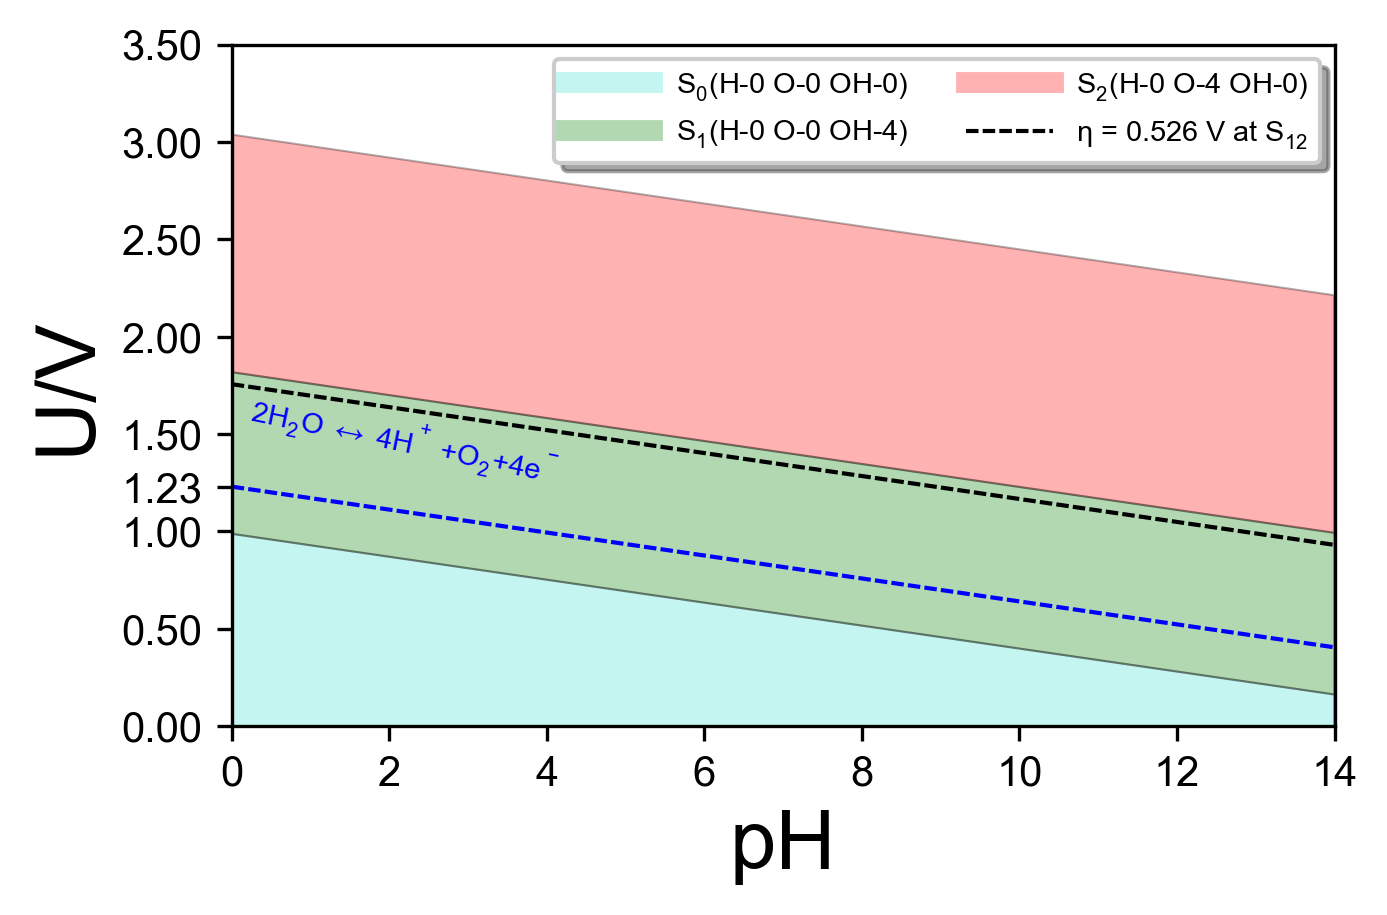

In [2]:
"""Forked from Cathub Project
   revised by hongye 2021/07/03
"""
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import scipy 
import subprocess
import matplotlib.ticker 
from matplotlib import rc
from matplotlib.path import Path
from matplotlib.patches import PathPatch

kbt = 0.0256               # KbT = 0.0256 eV Kb：Boltzmann constant 1.380649 × 10^-23 J/K  T：298.15 K
                           #Convert J to eV 1eV = 1.60217733×10^-19(J)
const = kbt*np.log(10)     
Umin=0.0
Umax=3.04

#calculated with 400 eV(cutoff??) ,O_s
#Units: eV
#At finite pH and potential, the free energy of H+(aq) + e− ↔ 1/2H2(g) is (p(H2) = 1 bar)
# ΔG = eUSHE + kBT*ln10*pH
h2  =  -6.759300
h2o =  -14.01977

zpeh2o = 0.5741    # exp. NIST 0.5584250
zpeh2  = 0.27283   # exp. NIST 0.27283
tsh2o  = 0.67      # 1 bar pressure
tsh2   = 0.41      # exp.

#monicas new ZPEs calulate O，OH, OOH, H atom ZPE energy adsorb at surface
zpeo   = 0.065     #0.113 Max. G IrO2
zpeoh  = 0.37      #0.397 Max. G IrO2
zpeooh = 0.44   #stays the same

#ΔZPE-TΔS  
#ΔZPE = ZPE(adsorbate) - ZPE(gas) 
#ΔS = S298.15K-S0K = S298.15K
dso   = zpeo -(zpeh2o-zpeh2 -tsh2o+tsh2)                  # Entropy of O
dsoh  = zpeoh -(zpeh2o -0.5*zpeh2 -tsh2o+ 0.5*tsh2)       # Entropy of OH
dsooh = zpeooh-(2*zpeh2o -1.5*zpeh2 -2*tsh2o+ 1.5*tsh2)   # Entropy of OOH
dsh   = dsoh-dso                                          # Entropy of H

def addO(x,y):
    return -(h2o-h2)-2*(y+x*const)+dso  

def addOH(x,y):
    return -(h2o-0.5*h2)-(y+x*const)+dsoh

def addOOH(x,y):
    return -(2*h2o-1.5*h2)-3*(y+x*const)+dsooh

def addH2O(x,y):
    return -(h2o)-(zpeh2o-tsh2o)

def addH(x,y):
    return -0.5*h2+1*(y+x*const)+dsh

class SurfPourbaix:
    """
    Generating Surface Pourbaix Diagrams
    format:
    surfs = [
    [ clean_surface energy, 0,0,0],   # clean surface 
    [ surface with adsorbate,i,j,k], # clean surface  + 4 OH adsorbates
    ]
    i:type(float) H atoms number at surface
    j:type(float) O atoms number at surface
    k:type(float) OH atoms number at surface
    surfs[0][0] should be clean surface      """
    def __init__(self,surfs):
       self.surfs = surfs      

    def dg(self,i,x,y):
        """if you want calculate OOH,CO or another adsorbates please 
           revised this module"""
        return (self.surfs[i][0] -self.surfs[0][0]  
               + self.surfs[i][1]* addH(x,y) + self.surfs[i][2]* addO(x,y) 
               + self.surfs[i][3]* addOH(x,y))
        
    def pourbaix_plotter(self):
        nsurfs = len(self.surfs)
        pH = np.arange(0,14,0.01)
        U  = np.arange(Umin,Umax,0.01)

        pH_value=0  
        lowest_surfaces=[]
        crossover=[]
        uniquesurf=[]

        for potential in U:
            values=[]
            for num in range(nsurfs):
                values.append(self.dg(num,pH_value,potential))
            sorted_values=sorted(range(len(values)), key=lambda num: values[num])
            lowest_surfaces.append(sorted_values[0])

        uniquesurf.append(lowest_surfaces[0])
        old_value=lowest_surfaces[0]
        crossover.append(Umin)

        for num in range(len(U)):
            if(lowest_surfaces[num]!=old_value):
                uniquesurf.append(lowest_surfaces[num])
                crossover.append(U[num])
                old_value=lowest_surfaces[num]

        crossover.append(Umax)

        fig_width_pt = 1.8*246.0  
        inches_per_pt = 1.0/72.27                              
        golden_mean = (np.sqrt(5)-1.0)/2.0      # Aesthetic ratio
        fig_width = fig_width_pt*inches_per_pt  # width in inches
        fig_height =fig_width*golden_mean       # height in inches
        fig_size = [fig_width,fig_height]

        font_size = 10
        tick_font_size = 10
        xlabel_pad = 8
        ylabel_pad = 18

        matplotlib.rcParams['ps.usedistiller'] = 'xpdf'
        matplotlib.rcParams['font.family'] = 'sans-serif'
        matplotlib.rcParams['font.sans-serif'] = 'Arial'
        matplotlib.rcParams['font.size'] = 10
        matplotlib.rcParams['axes.labelsize'] = 2*font_size
        matplotlib.rcParams['legend.fontsize'] = font_size
        matplotlib.rcParams['xtick.labelsize'] = tick_font_size
        matplotlib.rcParams['ytick.labelsize'] = tick_font_size
        matplotlib.rcParams['mathtext.default'] = 'regular'
        matplotlib.rcParams['lines.linewidth'] = 1.


        fig = plt.figure(figsize=fig_size,dpi=300)
        ax = fig.add_axes([0.2, 0.2, 0.6, 0.6])
        ax.axis([0, 14, Umin,Umax])
        ax.set_xlabel(r'pH')
        ax.set_ylabel(r'U/V')

        extraticks=[1.23]
        plt.yticks(list(plt.yticks()[0]) + extraticks)

        color=['turquoise', 'green', 'red','blue', 'gray', 'gold', 'gray20']

        for num in range(len(uniquesurf)):
            k = uniquesurf[num]
            foo= r"S$_{%i}$(H-%i O-%i OH-%i)" % (k, self.surfs[k][1], self.surfs[k][2],self.surfs[k][3])
            fbk = {'lw':0.5, 'edgecolor':'black'}
            ax.fill_between(pH,crossover[num]-pH*const, crossover[num+1]-pH*const, facecolor=color[num],alpha=0.3,**fbk) # This line maybe wrong
            #Be carefully This line maybe wrong 
            plt.plot([], [], color=color[num],alpha=0.3, linewidth=5,label=foo)

        Vover=0.526
        y=1.23+Vover -pH*const
        llabel='$\eta$ = '+ repr(Vover)+' V at S$_{12}$'
        plt.plot(pH,y,'-',color='black', lw=1, dashes=(3,1),label=llabel)

        plt.plot(pH,1.23-pH*const,'--',color='blue',lw=1, dashes=(3,1))
        ax.text(0.2,1.25,r'2H$_2$O $\leftrightarrow$ 4H$^+$ +O$_2$+4e$^-$',color='blue',rotation=-11.6,fontsize='x-small')

        plt.legend(ncol=2, fancybox=True, shadow=True, fontsize='x-small',handlelength=3)
        
        fig = plt.gcf()

        return fig
surfs = [
    [ -541.29070522, 0,0,0],   # clean surface 
    [ -581.50171715, 0, 0, 4], # clean surface  + 4 OH adsorbates
    [ -559.21450110, 0, 4, 0], # clean surface  + 4 O adsorbates 
    ]
SurfPourbaix(surfs).pourbaix_plotter()
fig1 = plt.gcf()